mse2 :　回帰問題　sinxを近似
　　参考：PyTorchで色々な非線形関数を回帰してみたらすごかった

 https://watlab-blog.com/2021/06/14/pytorch-nonlinear-regression/

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


ライブラリのimport

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 7.0 MB/s 


In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

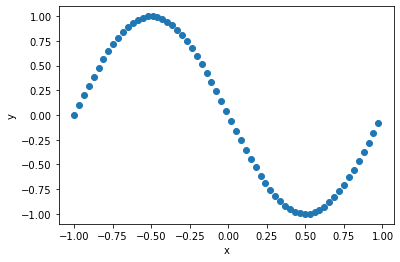

In [6]:
import matplotlib.pyplot as plt

np.random.seed(1)

input_data   = np.arange( 0, np.pi*2.0, 0.1 )
correct_data = np.sin( input_data )
n_data = len( correct_data )

# 入力を[-1.0,1.0]の範囲に
input_data = ( input_data - np.pi )/ np.pi

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter( input_data, correct_data)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

ニューラルネットワークの定義

In [7]:
"""def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;
"""

class Net(torch.nn.Module):
  
  def __init__( self, t ):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(1,32)
    self.fc2 = torch.nn.Linear(32,16)
    self.fc3 = torch.nn.Linear(16,1)
    self.target = t

  def forward(self, x):
    y = torch.nn.functional.relu(self.fc1(x))
    y = torch.nn.functional.relu(self.fc2(y))
    #y = F.sigmoid(self.fc2(x))
    y = self.fc3(y)
    #y = self.fc2(y)
    self.out = y

    #y = mean_squared_error( x, self.target )
    loss = nn.MSELoss()
    output = loss( y, self.target )
    #print('loss', output )
    return output

# for test network
class Net1(torch.nn.Module):
  def __init__( self, t ):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(1,3)
    self.fc2 = torch.nn.Linear(3,1)
    self.target = t

  def forward(self, x):
    #y = torch.nn.functional.relu(self.fc1(x))
    y = F.sigmoid(self.fc1(x))
    y = self.fc2(y)
    self.out = y

    #y = mean_squared_error( x, self.target )
    loss = nn.MSELoss()
    output = loss( y, self.target )
    #print('loss', output )
    return output


計算グラフをJSONファイルに出力する

In [8]:
def generate_json( json_path, input, target ):

    model = Net( target )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [9]:
torch.manual_seed( 1 )

input_data   = input_data.reshape(-1,1)
correct_data = correct_data.reshape(-1,1)
x_tensor = torch.from_numpy(input_data).float()
y_tensor = torch.from_numpy(correct_data).float()

batchs=63
xb = x_tensor[0:batchs,:]
yb = y_tensor[0:batchs,:]

project = 'mse2'
json_path = './network/' + project +'.json'

xb.requires_grad = True

model = generate_json( json_path, xb, yb )

[SAVE] ./network/mse2.json
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc1]/weight/fc1
skip: Net/Linear[fc2]/weight/fc2
skip: Net/Linear[fc2]/weight/fc2
skip: Net/Linear[fc3]/weight/fc3
skip: Net/Linear[fc3]/weight/fc3


一回の順伝播、逆伝播のC++コードを生成する

In [10]:
folder = "./mse"
CV.convert_cpp_code( project, folder, model, xb, json_path )

[JSON] ./network/mse2.json
{'name': 'Net/Linear[fc1]/weight/weight.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/bias.7', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2]/weight/weight.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2]/bias/bias.9', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc3]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 9}
{'name': 'Net/Linear[fc3]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [11], 'sorted_id': 10}
[PARAM] ./mse/mse2_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [63, 1], 'out': [3], 'sorted_id': 0}
{'name': 'Net/Linear[fc1]/weight/weight.7', 

In [11]:
# check code
with torch.set_grad_enabled(True):
  model.train()
  yy = model( xb )
  print("output",yy)
  yy.backward()
  print("input",xb.grad)

output tensor(0.5289, grad_fn=<MseLossBackward0>)
input tensor([[ 1.1412e-04],
        [ 2.0979e-04],
        [ 3.0452e-04],
        [-4.6669e-05],
        [-5.7151e-05],
        [-6.7198e-05],
        [-7.6710e-05],
        [-8.5591e-05],
        [-9.3752e-05],
        [-1.0111e-04],
        [-1.0760e-04],
        [-7.3139e-04],
        [-7.6037e-04],
        [-7.8262e-04],
        [ 3.0363e-04],
        [ 3.0701e-04],
        [ 3.0766e-04],
        [ 3.3594e-04],
        [ 3.3065e-04],
        [-7.1371e-04],
        [-6.8851e-04],
        [-6.5723e-04],
        [-1.1413e-03],
        [-1.0624e-03],
        [-9.4614e-04],
        [-8.5267e-04],
        [-7.5204e-04],
        [-2.6044e-04],
        [-4.4141e-04],
        [-3.4581e-04],
        [-2.4784e-04],
        [-1.4848e-04],
        [-4.8708e-05],
        [ 5.0486e-05],
        [ 1.4812e-04],
        [ 2.4323e-04],
        [ 3.3488e-04],
        [ 4.2216e-04],
        [ 5.0421e-04],
        [ 5.8021e-04],
        [ 6.4942e-04],
 

C++コードをコンパイルする

In [14]:
!g++ -std=c++14 ./mse/mse2.cpp ./mse/mse2_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./mse/mse2

In [15]:
!./mse/mse2

### forward computation ...
 0.528857
### backward computation ...
input_grad{{ 0.000114},
 { 0.00021 },
 { 0.000305},
 {-0.000047},
 {-0.000057},
 {-0.000067},
 {-0.000077},
 {-0.000086},
 {-0.000094},
 {-0.000101},
 {-0.000108},
 {-0.000731},
 {-0.00076 },
 {-0.000783},
 { 0.000304},
 { 0.000307},
 { 0.000308},
 { 0.000336},
 { 0.000331},
 {-0.000714},
 {-0.000689},
 {-0.000657},
 {-0.001141},
 {-0.001062},
 {-0.000946},
 {-0.000853},
 {-0.000752},
 {-0.00026 },
 {-0.000441},
 {-0.000346},
 {-0.000248},
 {-0.000148},
 {-0.000049},
 { 0.00005 },
 { 0.000148},
 { 0.000243},
 { 0.000335},
 { 0.000422},
 { 0.000504},
 { 0.00058 },
 { 0.000649},
 { 0.00114 },
 { 0.001227},
 { 0.0013  },
 { 0.001245},
 { 0.001285},
 { 0.00131 },
 { 0.001321},
 { 0.001318},
 { 0.0013  },
 { 0.001268},
 { 0.001222},
 { 0.001163},
 { 0.001091},
 { 0.001007},
 { 0.000451},
 { 0.000398},
 { 0.000341},
 { 0.000279},
 { 0.000215},
 { 0.000147},
 {-0.000025},
 {-0.000002}}


学習の実行(python版)

In [16]:
torch.manual_seed( 1 )

epochs = 2000

net = Net( y_tensor )
net.train()

lr = 0.01
opt = torch.optim.SGD(net.parameters(), lr)
#opt = torch.optim.Adam(net.parameters(), lr )

x_tensor.requires_grad = True

batch_size = 9
n_batch = len(x_tensor) // batch_size  # 1エポックあたりのバッチ数
print("batch ",n_batch,batch_size)

epoch_loss = []
for i in range(epochs):

    # -- 学習 -- 
    """
    opt.zero_grad()
    loss = net( x_tensor )
    total_loss = loss;
    loss.backward()
    opt.step()
    """
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    #for idx in index_random:
    for idx in range(n_batch):
        
        # ミニバッチを取り出す
        """
        x = x_tensor[ idx:idx+1 ]
        t = y_tensor[ idx:idx+1 ]
        #print(idx,x,t)
        """

        mb_index = index_random[ idx*batch_size : (idx+1)*batch_size ]
        x = x_tensor[ mb_index,:]
        t = y_tensor[ mb_index,:]
        
        # 順伝播と逆伝播
        net.target = t
        loss = net( x )
        total_loss += loss;
        #print("loss",loss)

        opt.zero_grad()
        loss.backward()
        opt.step()
    #"""
    # -- 誤差 --
    print("epoch: {} loss: {}".format(i, total_loss))
    epoch_loss.append( total_loss )

net.target = y_tensor
loss1 = net( x_tensor )

batch  7 9
epoch: 0 loss: 3.6137804985046387
epoch: 1 loss: 3.3821678161621094
epoch: 2 loss: 3.202080726623535
epoch: 3 loss: 3.0389389991760254
epoch: 4 loss: 2.892347574234009
epoch: 5 loss: 2.7466061115264893
epoch: 6 loss: 2.607574224472046
epoch: 7 loss: 2.4707016944885254
epoch: 8 loss: 2.366652250289917
epoch: 9 loss: 2.2197823524475098
epoch: 10 loss: 2.106710910797119
epoch: 11 loss: 2.001077175140381
epoch: 12 loss: 1.898061752319336
epoch: 13 loss: 1.8142292499542236
epoch: 14 loss: 1.712435007095337
epoch: 15 loss: 1.6313889026641846
epoch: 16 loss: 1.5574402809143066
epoch: 17 loss: 1.4987295866012573
epoch: 18 loss: 1.4270442724227905
epoch: 19 loss: 1.3785794973373413
epoch: 20 loss: 1.3321971893310547
epoch: 21 loss: 1.2915775775909424
epoch: 22 loss: 1.2500700950622559
epoch: 23 loss: 1.2205064296722412
epoch: 24 loss: 1.2030971050262451
epoch: 25 loss: 1.173769235610962
epoch: 26 loss: 1.153060793876648
epoch: 27 loss: 1.1334314346313477
epoch: 28 loss: 1.12177228927

収束状況グラフを描画する

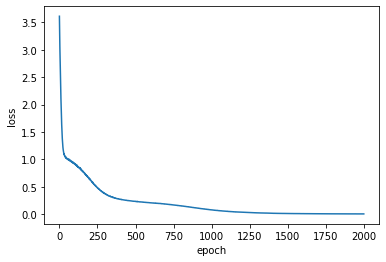

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

学習後のデータを描画する

(63, 1)


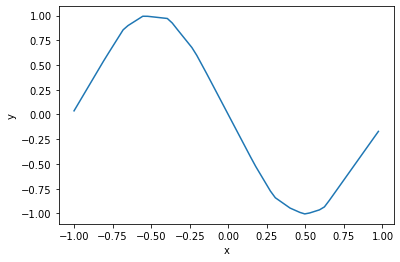

In [18]:
o = net.out.to('cpu').detach().numpy().copy()
print(o.shape)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(input_data, o)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

学習用データファイル、学習ループのC++コードを生成する

In [21]:
CV.convert_data_file( project, folder, inp_data=input_data, target_data=correct_data )
CV.convert_train_code( project, folder, json_path, sol="mse", epochs=2000, batch=9, inp_data=input_data, target_data=correct_data )

datafile key :  inp_data
datafile key :  target_data
[DATA] ./mse/mse2_data.cpp
[JSON] ./network/mse2.json
epoch_num :  2000
batch_size :  9
lr :  0.01
inp shape (63, 1) 2
inp  shape :  1 {63,1}
pred shape :  0 
target shape :  1 {63,1}
div :  False
unpack0 prim::ListUnpack
unpack1 aten::broadcast_tensors 0
unpack2 prim::ListConstruct 0
unpack original no:  11 15
unpack0 prim::ListUnpack
unpack1 aten::broadcast_tensors 1
unpack2 prim::ListConstruct 1
unpack original no:  12 16
mse_no :  11 12
batch_size: 9
inp_shape: {63,1}
[TRAIN]  ./mse/mse2_train.cpp


学習用C++コードをコンパイル、リンクする

In [20]:
!g++ -std=c++14 ./mse/mse2_train.cpp ./mse/mse2_param.cpp ./mse/mse2.cpp ./mse/mse2_data.cpp -D_NOTEBOOK -D_TRAIN -I ../../../xtensor -lcblas -o ./mse/mse2_train

In [22]:
!./mse/mse2_train

epoch_num : 2000
indata shape   : 63,1
batch  number  : 7,9
learning ratio : 0.01
total_loss : epoch 0 : loss 3.6291
total_loss : epoch 1 : loss 3.37867
total_loss : epoch 2 : loss 3.20884
total_loss : epoch 3 : loss 3.03129
total_loss : epoch 4 : loss 2.89771
total_loss : epoch 5 : loss 2.7474
total_loss : epoch 6 : loss 2.59818
total_loss : epoch 7 : loss 2.47471
total_loss : epoch 8 : loss 2.34494
total_loss : epoch 9 : loss 2.23556
total_loss : epoch 10 : loss 2.11225
total_loss : epoch 11 : loss 1.99432
total_loss : epoch 12 : loss 1.89782
total_loss : epoch 13 : loss 1.79782
total_loss : epoch 14 : loss 1.73392
total_loss : epoch 15 : loss 1.63004
total_loss : epoch 16 : loss 1.55173
total_loss : epoch 17 : loss 1.49737
total_loss : epoch 18 : loss 1.42343
total_loss : epoch 19 : loss 1.39497
total_loss : epoch 20 : loss 1.32871
total_loss : epoch 21 : loss 1.30569
total_loss : epoch 22 : loss 1.25276
total_loss : epoch 23 : loss 1.22471
total_loss : epoch 24 : loss 1.20324
total

In [23]:
# read output file from c++ code
f = open('./mse/mse2.out', 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

f2 = open('./mse/mse2.pred', 'r')

x_new = []
y_pred = []
datalist = f2.readlines()
for data in datalist:
  ds = data.split(',')
  x_new.append( float(ds[0]))
  y_pred.append( float(ds[1]))

f2.close()

print("pred =", len(x_new))
print( x_new )
print( y_pred )


epoch = 2000
[3.629097, 3.378666, 3.208838, 3.031287, 2.897715, 2.747402, 2.598182, 2.47471, 2.344935, 2.235563, 2.112252, 1.99432, 1.897821, 1.797823, 1.733919, 1.630036, 1.551729, 1.497367, 1.423433, 1.394972, 1.328713, 1.305689, 1.25276, 1.224709, 1.203241, 1.183334, 1.152702, 1.140195, 1.125022, 1.116997, 1.097068, 1.098873, 1.080709, 1.066754, 1.063083, 1.05578, 1.050623, 1.059742, 1.038626, 1.035638, 1.043894, 1.0365, 1.02914, 1.038498, 1.034449, 1.028563, 1.021555, 1.017707, 1.020979, 1.023363, 1.016062, 1.021, 1.007355, 1.00938, 1.010996, 0.996965, 1.003231, 0.995396, 1.005935, 0.996663, 0.991548, 0.994986, 0.985909, 0.99073, 0.984909, 0.981508, 0.980202, 0.984971, 0.98052, 0.979509, 0.980942, 0.977018, 0.970844, 0.970633, 0.978935, 0.964385, 0.966937, 0.976533, 0.960448, 0.951684, 0.953548, 0.958894, 0.958355, 0.947501, 0.949273, 0.953258, 0.942322, 0.94849, 0.938505, 0.938117, 0.930409, 0.937569, 0.930467, 0.932182, 0.933221, 0.925407, 0.926997, 0.925166, 0.92167, 0.911003, 0

収束状況グラフを描画する

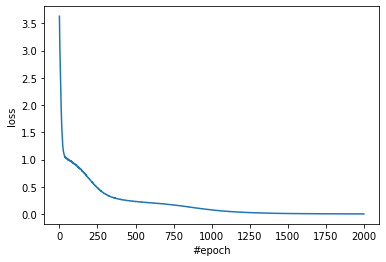

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

学習後のデータを描画する

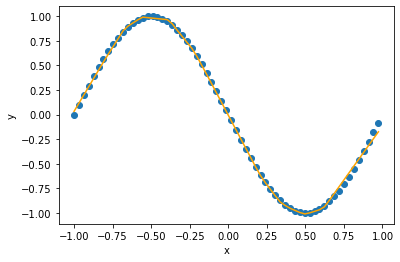

In [25]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(input_data,correct_data )
ax.plot( x_new, y_pred, c='orange')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()